In [101]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [102]:
training_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="data", train=False, download=True, transform=transforms.ToTensor())

In [113]:
training_size = int(len(training_dataset)*0.8)
val_size = len(training_dataset) - training_size
training_data, val_data = torch.utils.data.random_split(training_dataset, [training_size, val_size])

In [104]:
image_shape = training_dataset.data[0].shape
if len(image_shape)==2:
  input_channels = 1
  input_dim = tuple(image_shape)
else:
  input_channels = image_shape[0]
  input_dim = tuple(image_shape[1:])

In [114]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
num_classes = len(training_dataset.classes)
embed_size = 2
batch_size = 200

training_loader = DataLoader(training_data, shuffle=False, batch_size = batch_size)
val_loader = DataLoader(val_data, shuffle=False, batch_size = batch_size)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size = batch_size)

In [106]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)

In [107]:
class FeedForwardClassifier(torch.nn.Module):
    def __init__(self, output_dim, embed_size) -> None:
        super().__init__()
        self.fc1 = torch.nn.Linear(embed_size, 250)
        self.fc2 = torch.nn.Linear(250, output_dim)

    def forward(self, embedding):
        x = embedding.squeeze()
        x = torch.nn.ReLU()(self.fc1(x))
        output = self.fc2(x)
        return output

    def predict(self, embedding):
        logits = self.forward(embedding)
        probabilities = torch.nn.Softmax()(logits)
        return torch.argmax(probabilities, dim=1)

In [119]:
# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
        ])
        self.dense_mu = torch.nn.Linear(1024, z_dim)
        self.dense_logvar = torch.nn.Linear(1024, z_dim)
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        mu = self.dense_mu(x)
        logvar = self.dense_logvar(x)
        return mu, logvar
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        for layer in self.model:
            x = layer(x)
        return x
    
class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(logvar / 2)
        eps = torch.randn_like(std)
        z = mu 
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed

In [120]:
model = Model(z_dim=embed_size).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

model.train()

Model(
  (encoder): Encoder(
    (model): ModuleList(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (3): LeakyReLU(negative_slope=0.01)
      (4): Flatten()
      (5): Linear(in_features=6272, out_features=1024, bias=True)
      (6): LeakyReLU(negative_slope=0.01)
    )
    (dense_mu): Linear(in_features=1024, out_features=2, bias=True)
    (dense_logvar): Linear(in_features=1024, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (model): ModuleList(
      (0): Linear(in_features=2, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=6272, bias=True)
      (3): ReLU()
      (4): Reshape()
      (5): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (6): ReLU()
      (7): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      

In [121]:
num_samples = 200
epochs = 10
patience = 5
delta = 1e-4
best_score = None
num_bad_epochs = 0

In [111]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size(1)
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd

In [122]:
for epoch in range(epochs):
  # Training Loop
  epoch_loss = 0
  for image, label in tqdm(training_loader):
      optimizer.zero_grad()
      image = image.to(DEVICE)
      label = label.type(torch.LongTensor).to(DEVICE)

      # Passing the input image through VAE
      embedding, out = model.forward(image)

      # Mean Square Error Loss (Reconstruction loss in VAE Loss function)
      mse_loss = torch.nn.functional.mse_loss(out, image)

      # Maximum Mean Discrepancy
      true_samples =  torch.randn(num_samples, embed_size).to(DEVICE)
      mmd = compute_mmd(true_samples, embedding)

      # Total Loss = Reconstruction Loss + Maximum Mean Discrepancy
      loss = mse_loss + mmd

      loss.backward() # Perform Back-Propogation
      optimizer.step() # Performs a single optimization step (parameter update)
      epoch_loss += loss
      del loss, out

  # Validation Loop
  val_loss = 0
  with torch.no_grad():
    for image, label in tqdm(val_loader):
        image = image.to(DEVICE)
        label = label.type(torch.LongTensor).to(DEVICE)

        true_samples =  torch.randn(num_samples, embed_size).to(DEVICE)
        embedding, out = model.forward(image)

        mse_val_loss = torch.nn.functional.mse_loss(out, image)
        mmd_val_loss = compute_mmd(true_samples, embedding)
        val_loss += (mse_val_loss + mmd_val_loss)
        
  print(f'Epoch: {epoch}; Training Loss: {epoch_loss}; Validation Loss: {val_loss}')
  
  # Early Stopping
  if best_score == None:
    best_score = val_loss
    encoder_state_dict = model.state_dict()
    torch.save(encoder_state_dict, "model_weights.pt")
  elif best_score-val_loss>delta:
    best_score = val_loss
    encoder_state_dict = model.state_dict()
    num_bad_epochs = 0
    torch.save(encoder_state_dict, "model_weights.pt")
  else:
    num_bad_epochs += 1
  
  if num_bad_epochs==patience:
    print(f'Early Stopping at epoch {epoch}')
    break

100%|██████████| 60/60 [00:01<00:00, 49.49it/s]


Epoch: 0; Training Loss: 58.66120147705078; Validation Loss: 13.987787246704102


100%|██████████| 60/60 [00:01<00:00, 49.12it/s]


Epoch: 1; Training Loss: 56.87114715576172; Validation Loss: 14.297755241394043


100%|██████████| 60/60 [00:01<00:00, 48.79it/s]


Epoch: 2; Training Loss: 26.729124069213867; Validation Loss: 3.6511611938476562


100%|██████████| 60/60 [00:01<00:00, 48.91it/s]


Epoch: 3; Training Loss: 14.192726135253906; Validation Loss: 3.390651226043701


100%|██████████| 60/60 [00:01<00:00, 48.85it/s]


Epoch: 4; Training Loss: 13.073260307312012; Validation Loss: 3.2236711978912354


100%|██████████| 60/60 [00:01<00:00, 49.29it/s]


Epoch: 5; Training Loss: 12.545344352722168; Validation Loss: 3.1236913204193115


100%|██████████| 60/60 [00:01<00:00, 49.06it/s]


Epoch: 6; Training Loss: 12.028119087219238; Validation Loss: 3.0598766803741455


100%|██████████| 60/60 [00:01<00:00, 49.25it/s]


Epoch: 7; Training Loss: 11.728211402893066; Validation Loss: 2.951960325241089


100%|██████████| 60/60 [00:01<00:00, 48.62it/s]


Epoch: 8; Training Loss: 11.540290832519531; Validation Loss: 2.9061026573181152


100%|██████████| 60/60 [00:01<00:00, 48.92it/s]


Epoch: 9; Training Loss: 11.139874458312988; Validation Loss: 2.7909650802612305


## **Plot Latent Space**

0it [00:00, ?it/s]

240it [00:04, 49.62it/s]
100%|██████████| 1000/1000 [00:03<00:00, 276.68it/s]


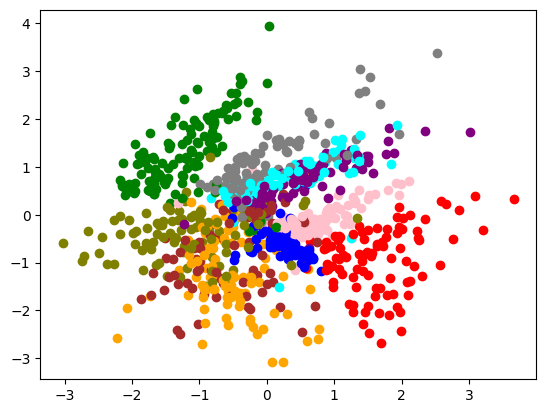

In [123]:
# Load Models
pca = PCA(n_components=2)
model.load_state_dict(torch.load("./model_weights.pt"))

# Label, Embedding Matrices
embedding = torch.zeros((training_size, embed_size))
y = torch.zeros(len(training_loader.dataset))

with torch.no_grad():
  for i, (image, label) in tqdm(enumerate(training_loader)):
    # image = image.squeeze()
    image = image.to(DEVICE)
    label = label.to(torch.int32).to(DEVICE)

    z, _ = model.forward(image)
    embedding[i*batch_size:min((i+1)*batch_size, training_size)] = z
    y[i*batch_size:min((i+1)*batch_size, training_size)] = label

if embed_size != 2:
  embedding = pca.fit_transform(embedding)

colors = ['red','green','blue','orange','purple','brown','pink','gray','olive','cyan']
for i in tqdm(range(1000)):
    z = embedding[i]
    plt.scatter(z[0], z[1], c=colors[int(y[i])])
plt.savefig("./latent.png", format="png")
plt.show()

In [124]:
epochs = 10
patience = 5
delta = 1e-4
best_score = None
num_bad_epochs = 0

In [125]:
classifier = FeedForwardClassifier(output_dim=num_classes, embed_size=embed_size).to(DEVICE)
classifier_optimizer = torch.optim.Adam(classifier.parameters())

classifier.train()

for epoch in range(epochs):
  # Training Loop
  epoch_loss = 0
  for image, label in tqdm(training_loader):
      classifier_optimizer.zero_grad()
      image = image.to(DEVICE)
      label = label.type(torch.LongTensor).to(DEVICE)

      with torch.no_grad():
        # Passing the input image through VAE
        embedding, out = model.forward(image)

      # Passing the latent representation through Classifier
      prediction = classifier.forward(embedding)
      loss = torch.nn.CrossEntropyLoss()(prediction, label)

      loss.backward() # Perform Back-Propogation
      classifier_optimizer.step() # Performs a single optimization step (parameter update)
      epoch_loss += loss
      del loss, out

  # Validation Loop
  val_loss = 0
  with torch.no_grad():
    for image, label in tqdm(val_loader):
        image = image.to(DEVICE)
        label = label.type(torch.LongTensor).to(DEVICE)

        embedding, out = model.forward(image)
        prediction = classifier.forward(embedding)
        classification_loss = torch.nn.CrossEntropyLoss()(prediction, label)
        val_loss += classification_loss
        
  print(f'Epoch: {epoch}; Training Loss: {epoch_loss}; Validation Loss: {val_loss}')
  
  # Early Stopping
  if best_score == None:
    best_score = val_loss
    classifier_state_dict = classifier.state_dict()
    torch.save(classifier_state_dict, "classifier_weights.pt")
  elif best_score-val_loss>delta:
    best_score = val_loss
    classifier_state_dict = classifier.state_dict()
    num_bad_epochs = 0
    torch.save(classifier_state_dict, "classifier_weights.pt")
  else:
    num_bad_epochs += 1
  
  if num_bad_epochs==patience:
    print(f'Early Stopping at epoch {epoch}')
    break

100%|██████████| 60/60 [00:01<00:00, 48.97it/s]


Epoch: 0; Training Loss: 269.8162536621094; Validation Loss: 51.86894989013672


100%|██████████| 60/60 [00:01<00:00, 49.08it/s]


Epoch: 1; Training Loss: 193.52085876464844; Validation Loss: 47.327613830566406


100%|██████████| 60/60 [00:01<00:00, 49.03it/s]


Epoch: 2; Training Loss: 182.3379669189453; Validation Loss: 45.70768356323242


100%|██████████| 60/60 [00:01<00:00, 48.90it/s]


Epoch: 3; Training Loss: 177.18165588378906; Validation Loss: 44.742557525634766


100%|██████████| 60/60 [00:01<00:00, 48.89it/s]


Epoch: 4; Training Loss: 174.00909423828125; Validation Loss: 44.09954833984375


100%|██████████| 60/60 [00:01<00:00, 49.32it/s]


Epoch: 5; Training Loss: 171.8083038330078; Validation Loss: 43.61872863769531


100%|██████████| 60/60 [00:01<00:00, 48.88it/s]


Epoch: 6; Training Loss: 170.12469482421875; Validation Loss: 43.23501968383789


100%|██████████| 60/60 [00:01<00:00, 49.14it/s]


Epoch: 7; Training Loss: 168.769775390625; Validation Loss: 42.9141731262207


100%|██████████| 60/60 [00:01<00:00, 48.64it/s]


Epoch: 8; Training Loss: 167.6425323486328; Validation Loss: 42.64621353149414


100%|██████████| 60/60 [00:01<00:00, 49.30it/s]

Epoch: 9; Training Loss: 166.7071990966797; Validation Loss: 42.42451095581055


In [127]:
model.load_state_dict(torch.load("./model_weights.pt"))
classifier.load_state_dict(torch.load("./classifier_weights.pt"))

model.eval()
classifier.eval()

correct = 0
with torch.no_grad():
  for image, label in tqdm(test_loader):
    image = image.to(DEVICE)
    label = label.to(torch.int32).to(DEVICE)

    embedding, _ = model.forward(image)
    prediction = classifier.predict(embedding).to(torch.int32)

    correct += int(sum(prediction==label))
print()
print(f"Accuracy : {100*correct/len(test_loader.dataset):.2f}")

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_643054/2900843493.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probabilities = torch.nn.Softmax()(logits)
100%|██████████| 50/50 [00:01<00:00, 46.22it/s]


Accuracy : 75.16
